<a href="https://colab.research.google.com/github/HST0077/HYOTC/blob/main/copula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3차원 그래프**

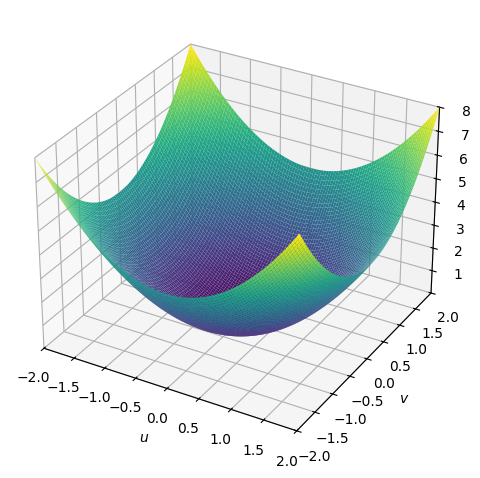

In [3]:
import sympy as smp

u,v = smp.symbols('u v')
smp.plotting.plot3d(u**2+v**2, (u,-2,2), (v,-2,2))

In [7]:
# interactive mode, plotly 패키지 사용
import plotly.graph_objects as go
import numpy as np

u = np.linspace(-2, 2, 100)
v = np.linspace(-2, 2, 100)
U, V = np.meshgrid(u, v)
Z = U**2 + V**2

fig = go.Figure(data=[go.Surface(z=Z, x=U, y=V)])
fig.show()

# **2변량 정규분포의 pdf 그려보기**

In [8]:
# multivariate normal random samples by scipy
import numpy as np
from scipy.stats import multivariate_normal

# 평균벡터 & 공분산행렬
mean = [0, 0, 0]
cov  = [[1, -0.2, -0.3],
        [-0.2, 1, 0.9],
        [-0.3, 0.9, 1]]

# scipy.stats.multivariate_normal 객체 생성
rv = multivariate_normal(mean=mean, cov=cov)

# x1, x2 격자 생성 (세 번째 변수 x3는 0으로 고정)
x1 = np.linspace(-3, 3, 100)
x2 = np.linspace(-3, 3, 100)
X1, X2 = np.meshgrid(x1, x2)

# x3 = 0으로 고정된 평면
X3 = np.zeros_like(X1)

# (x1, x2, x3=0) 점들을 하나의 배열로 쌓기
# scipy.stats.multivariate_normal.pdf는 (..., 3) 형태도 받아줌
pos = np.stack((X1, X2, X3), axis=-1)   # shape: (100, 100, 3)

# 각 점에서의 pdf 값 계산
Z = rv.pdf(pos)  # shape: (100, 100)

# Plotly로 3D surface plot
fig = go.Figure(data=[
    go.Surface(
        x=X1,
        y=X2,
        z=Z,
        # colorscale="Viridis"  # 원하면 색상도 지정 가능
    )
])

fig.update_layout(
    title="3D PDF slice: f(x1, x2, x3=0)",
    scene=dict(
        xaxis_title="x1",
        yaxis_title="x2",
        zaxis_title="pdf(x1, x2, x3=0)"
    ),
    template="plotly_white"
)

fig.show()

# X,Y는 서로 0.5의 상관관계를 갖고 있고, X는 평균이 2인 포아송분포, Y는 평균 1, 표준편차 3인 정규분포를 따른다고 할 때, 1000쌍의 난수 쌍을 만들어어라.

matplotlib이 인식한 폰트 이름: NanumGothic
현재 설정된 폰트 패밀리: ['NanumGothic']


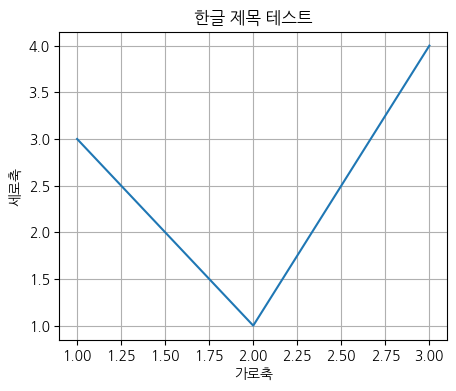

In [34]:
# 그래프 한글 출력 보완
# 1) 폰트 캐시 삭제 (이전 설정 깨끗이)
!rm -rf ~/.cache/matplotlib

# 2) 나눔고딕 TTF 파일 다운로드
!wget -q -O /content/NanumGothic.ttf \
  "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf"

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# 3) 폰트를 matplotlib fontManager에 등록
font_path = "/content/NanumGothic.ttf"
fm.fontManager.addfont(font_path)                 # ⭐ 이게 핵심
font_name = fm.FontProperties(fname=font_path).get_name()
print("matplotlib이 인식한 폰트 이름:", font_name)

# 4) 전역 설정
mpl.rcParams['font.family'] = font_name
mpl.rcParams['axes.unicode_minus'] = False

print("현재 설정된 폰트 패밀리:", mpl.rcParams['font.family'])

# 5) 테스트 플롯
plt.figure(figsize=(5,4))
plt.plot([1,2,3], [3,1,4])
plt.title("한글 제목 테스트")
plt.xlabel("가로축")
plt.ylabel("세로축")
plt.grid(True)
plt.show()


     X         Y
0  2.0  0.717101
1  2.0 -0.493758
2  3.0 -0.919089
3  2.0 -0.493101
4  2.0  2.335260

===== 상관관계(피어슨) =====
          X         Y
X  1.000000  0.451585
Y  0.451585  1.000000

===== 상관관계(스피어만) =====
          X         Y
X  1.000000  0.441481
Y  0.441481  1.000000


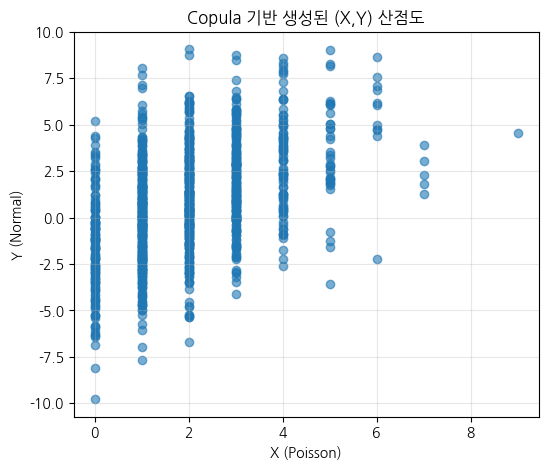

In [37]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------------------------------------
# 1. Copula 기반 난수 생성 설정
# -------------------------------------------------------
n = 1000                 # 샘플 수
rho = 0.5                # 목표 상관관계
mean_poisson = 2         # X ~ Poisson(2)
mu_y = 1                 # Y ~ Normal(1, 3)
sigma_y = 3

# -------------------------------------------------------
# 2. Gaussian Copula 샘플 생성
#    1) 상관 구조를 가진 정규쌍 (Z1, Z2) 생성
#    2) 각 변수를 CDF → Uniform(0,1)
#    3) Uniform을 각각 Poisson, Normal의 역변환을 적용
# -------------------------------------------------------

# 2-1. 상관행렬
cov = [[1, rho],
       [rho, 1]]

# 다변량 정규(표준정규)에서 1000쌍 생성
Z = np.random.multivariate_normal([0,0], cov, size=n)
Z1, Z2 = Z[:,0], Z[:,1]

# 2-2. CDF로 변환 → U1, U2 ~ Uniform(0,1)
U1 = st.norm.cdf(Z1)
U2 = st.norm.cdf(Z2)

# 2-3. 각 분포의 inverse CDF를 적용 (Copula 변환)
X = st.poisson.ppf(U1, mean_poisson)        # 포아송 역변환
Y = mu_y + sigma_y * st.norm.ppf(U2)        # 정규 역변환

# -------------------------------------------------------
# 3. 결과 DataFrame 정리
# -------------------------------------------------------
df = pd.DataFrame({"X": X, "Y": Y})
print(df.head())

# -------------------------------------------------------
# 4. 상관관계 검증 (피어슨, 스피어만)
# -------------------------------------------------------
pear_corr = df.corr(method="pearson")
spear_corr = df.corr(method="spearman")

print("\n===== 상관관계(피어슨) =====")
print(pear_corr)

print("\n===== 상관관계(스피어만) =====")
print(spear_corr)

# -------------------------------------------------------
# 5. 시각화 (산점도)
# -------------------------------------------------------
plt.figure(figsize=(6,5))
plt.scatter(X, Y, alpha=0.6)
plt.title("Copula 기반 생성된 (X,Y) 산점도")
plt.xlabel("X (Poisson)")
plt.ylabel("Y (Normal)")
plt.grid(alpha=0.3)
plt.show()